Goal: a scene classification model that classifies an image to one of 6 labels:
- Buildings
- Forests
- Mountains
- Glacier
- Street
- Sea

Dataset: https://www.kaggle.com/datasets/nitishabharathi/scene-classification?resource=download&select=train-scene+classification

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
tf.get_logger().setLevel('INFO')

/Users/ktnorton/anaconda3/envs/w207/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2022-10-17 17:30:33.324313: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load data

In [2]:
from PIL import Image

def generate_xy(df):
    X = []
    for i in df['image_name'].values:
        img = Image.open(f'train-scene classification/train/{i}')
        img_arr = np.array(img)
        if img_arr.shape[0] == 150:
            X.append(np.array(img))
        else:
            X.append(np.array(img.resize((150,150))))

    X = np.array(X)
    Y = df['label'].values
    
    return X, Y

In [35]:
samples_df = pd.read_csv('train-scene classification/train.csv')

val_df = samples_df.sample(frac=.2)
test_df = samples_df[~samples_df.index.isin(val_df.index)].sample(frac=.1)
train_df = samples_df[~samples_df.index.isin(val_df.index) & ~samples_df.index.isin(test_df.index)]

In [41]:
train_df.shape[0] + val_df.shape[0] + test_df.shape[0]

17034

In [40]:
samples_df.shape[0]

17034

In [42]:
train_X, train_Y = generate_xy(train_df)
val_X, val_Y = generate_xy(val_df)
test_X, test_Y = generate_xy(test_df)

## Exploratory Data Analysis

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
classes = samples_df['label'].unique()
classes

array([0, 4, 5, 1, 2, 3])

### Check class balance across train/val dataset

#### Whole dataset

<AxesSubplot:xlabel='label', ylabel='counts'>

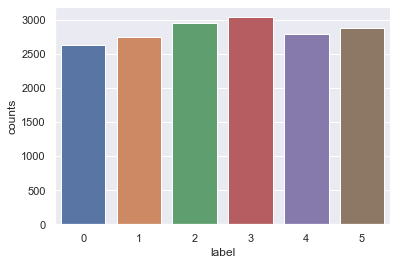

In [28]:
class_counts = samples_df.groupby(by='label').count().reset_index()
class_counts.rename(columns={'image_name':'counts'}, inplace=True)
sns.barplot(x='label', y='counts', data=class_counts) 

#### Train dataset

<AxesSubplot:xlabel='label', ylabel='counts'>

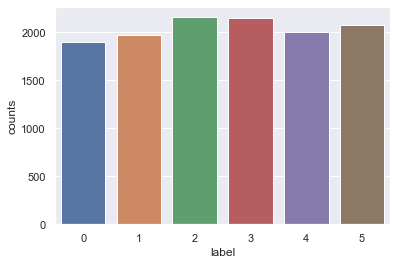

In [45]:
train_class_counts = train_df.groupby(by='label').count().reset_index()
train_class_counts.rename(columns={'image_name':'counts'}, inplace=True)
sns.barplot(x='label', y='counts', data=train_class_counts) 

#### Val dataset

<AxesSubplot:xlabel='label', ylabel='counts'>

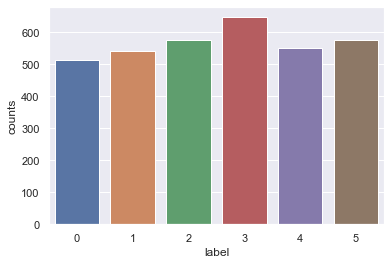

In [44]:
val_class_counts = val_df.groupby(by='label').count().reset_index()
val_class_counts.rename(columns={'image_name':'counts'}, inplace=True)
sns.barplot(x='label', y='counts', data=val_class_counts) 

#### Test dataset

<AxesSubplot:xlabel='label', ylabel='counts'>

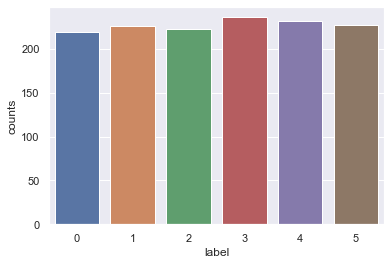

In [43]:
test_class_counts = test_df.groupby(by='label').count().reset_index()
test_class_counts.rename(columns={'image_name':'counts'}, inplace=True)
sns.barplot(x='label', y='counts', data=test_class_counts) 

## Train Model

In [54]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    """Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

    Returns:
    model: A tf.keras model (graph).
    """
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    model = keras.Sequential()
    for layer_size in hidden_layer_sizes:
        
        model.add(keras.layers.Dense(
          units=layer_size,
          activation=activation,
        ))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(
      units=n_classes,
      activation='softmax'
    ))
    
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate) if optimizer == 'SGD' \
             else tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(loss='sparse_categorical_crossentropy', 
                optimizer=optimizer, 
                metrics=['accuracy'])
    return model

In [69]:
model = build_model(n_classes=len(classes),
                      hidden_layer_sizes=[],
                      activation='relu',
                      optimizer='Adam',
                      learning_rate=.0005)

In [76]:
print('Training...')
n_epochs = 20
history = model.fit(
    x=train_X,
    y=train_Y,
    epochs=n_epochs,
    batch_size=16,
    validation_data=(val_X, val_Y),
    # validation_split=0.10,
    verbose=0)

Training...


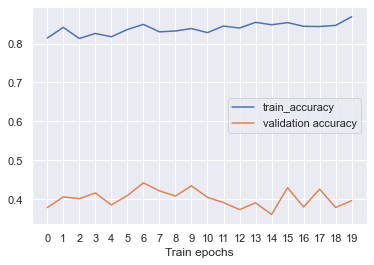

0.40425533056259155


In [77]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(n_epochs))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

model_eval = model.evaluate(x=test_X, y=test_Y, verbose=0,
                             return_dict=True)

test_accuracy = model_eval['accuracy']
print(test_accuracy)